In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import re
import networkx as nx
from operator import itemgetter
import warnings
import matplotlib.cm as mcm
import community
from community import community_louvain as cm
import leidenalg as la
import igraph as ig
from cdlib import algorithms
warnings.filterwarnings('ignore')

In [2]:
def get_list_by_keyword(subject, keyword):
    list_by_key = []
    indices = [i for i, x in enumerate(subject.split()) if keyword in x]
    if len(indices) == 0:
        return None
    list_by_key = [None] * len(indices)
    for idx in range(len(indices)):
        list_by_key[idx] = subject.split()[int(indices[idx]+1)].replace("'", "").replace(",", "")
    return list_by_key

In [3]:
#change path and name of files
path = '/Users/marta/Desktop/Master/covid_19/files/'
month=1

tweets = pd.read_csv(path+'COVID-19-Tweets/2020-0'+str(month)+'/tweets.csv', lineterminator='\n')
users = pd.read_csv(path+'COVID-19-Tweets/2020-0'+str(month)+'/users.csv', lineterminator='\n')

In [4]:
#user_screen_name.lower()
tweets['user_screen_name'] = tweets['user_screen_name'].str.lower()
tweets['rt_user_screen_name'] = tweets['rt_user_screen_name'].str.lower()
tweets['in_reply_to_screen_name'] = tweets['in_reply_to_screen_name'].str.lower()
#tweets = tweets.dropna(subset=['user_id'])
#tweets['user_id'] = [str(i) for i in tweets['user_id']]
users['screen_name'] = users['screen_name'].str.lower()

In [5]:
consecutive_retweets_df = pd.read_csv(path+'COVID-19-Tweets/retweets/rapid/2020-0'+str(month)+'/rapid_retweets_10.csv', lineterminator='\n')

In [6]:
retweets_threshold = 2

In [7]:
consecutive_retweets = consecutive_retweets_df

In [8]:
consecutive_retweets_count = consecutive_retweets.groupby(['user_screen_name','rt_user_screen_name']).size().reset_index(name='counts')
consecutive_retweets_count = consecutive_retweets_count[consecutive_retweets_count['counts']>=retweets_threshold]
consecutive_retweets_count.sort_values(by='counts', ascending=False).head(10)

,user_screen_name,rt_user_screen_name,counts
855,dokscho,business,194
2062,njmike731,cnn,149
2958,viriyabot,reuters,60
1632,kjgheroman,cnn,58
856,dokscho,businessinsider,57
1958,monitor_ph,who,47
2971,viriyabot,scmpnews,43
1929,monitor_ph,cdcgov,35
1483,jenssen_jonas,jenssen_jonas,29
2263,ratchet_clank10,ratchet_clank10,27


In [64]:
print('January')
consecutive_retweets_graph = nx.from_pandas_edgelist(consecutive_retweets_count,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(consecutive_retweets_graph))
isolated_nodes = list(nx.isolates(consecutive_retweets_graph))
print('Isoleted nodes:',len(isolated_nodes))
print('Strongly connected: ',nx.is_strongly_connected(consecutive_retweets_graph))
print('Number of connected components: ',nx.number_strongly_connected_components(consecutive_retweets_graph))
#print('Number of non connected components: ',len(nx.nodes(consecutive_retweets_graph))-nx.number_strongly_connected_components(consecutive_retweets_graph))
# Extract the giant connected component
Gcc = sorted((consecutive_retweets_graph.subgraph(c) for c in nx.strongly_connected_components(consecutive_retweets_graph)), key = len,reverse=True)[0]
#print("Number of nodes in the Gcc graph: ",len(Gcc.nodes()))
print("Number of edges in the Gcc graph: ",len(Gcc.edges()))
print("Gcc nodes: ",Gcc.nodes())
print("Gcc edges: ",Gcc.edges())

January
Name: 
Type: DiGraph
Number of nodes: 614
Number of edges: 525
Average in degree:   0.8550
Average out degree:   0.8550
Isoleted nodes: 0
Strongly connected:  False
Number of connected components:  611
Number of non connected components:  3
Number of edges in the Gcc graph:  6
Gcc nodes:  ['mailonline', 'dailymail', 'dailymailuk']
Gcc edges:  [('mailonline', 'dailymail'), ('mailonline', 'dailymailuk'), ('dailymail', 'dailymailuk'), ('dailymail', 'mailonline'), ('dailymailuk', 'dailymail'), ('dailymailuk', 'mailonline')]


In [10]:
consecutive_retweets_no_self = consecutive_retweets_count[consecutive_retweets_count['user_screen_name']!=consecutive_retweets_count['rt_user_screen_name']]
##
#

In [63]:
print('January')
consecutive_retweets_graph_nx = nx.from_pandas_edgelist(consecutive_retweets_no_self,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(consecutive_retweets_graph_nx))
isolated_nodes = list(nx.isolates(consecutive_retweets_graph_nx))
print('Isoleted nodes:',len(isolated_nodes))
print('Strongly connected: ',nx.is_strongly_connected(consecutive_retweets_graph_nx))
print('Number of connected components: ',nx.number_strongly_connected_components(consecutive_retweets_graph_nx))
#print('Number of non connected components: ',len(nx.nodes(consecutive_retweets_graph_nx))-nx.number_strongly_connected_components(consecutive_retweets_graph_nx))
# Extract the giant connected component
Gcc = sorted((consecutive_retweets_graph_nx.subgraph(c) for c in nx.strongly_connected_components(consecutive_retweets_graph_nx)), key = len,reverse=True)[0]
print("Number of nodes in the Gcc graph: ",len(Gcc.nodes()))
print("Number of edges in the Gcc graph: ",len(Gcc.edges()))
print("Gcc nodes: ",Gcc.nodes())
print("Gcc edges: ",Gcc.edges())

January
Name: 
Type: DiGraph
Number of nodes: 508
Number of edges: 419
Average in degree:   0.8248
Average out degree:   0.8248
Isoleted nodes: 0
Strongly connected:  False
Number of connected components:  505
Number of nodes in the Gcc graph:  3
Number of edges in the Gcc graph:  6
Gcc nodes:  ['mailonline', 'dailymail', 'dailymailuk']
Gcc edges:  [('mailonline', 'dailymail'), ('mailonline', 'dailymailuk'), ('dailymail', 'dailymailuk'), ('dailymail', 'mailonline'), ('dailymailuk', 'dailymail'), ('dailymailuk', 'mailonline')]


In [12]:
tuples = [tuple(x) for x in consecutive_retweets_no_self.values]
consecutive_retweets_graph = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['counts'])

In [13]:
n_vertices = consecutive_retweets_graph.vcount()
print("Number of vertices:", n_vertices)
print("Number of edges:", consecutive_retweets_graph.ecount())
print("Density of the graph:", 2*consecutive_retweets_graph.ecount()/(consecutive_retweets_graph.vcount()*(consecutive_retweets_graph.vcount()-1)))

Number of vertices: 508
Number of edges: 419
Density of the graph: 0.0032536613396698193


In [14]:
partition = la.find_partition(consecutive_retweets_graph, la.ModularityVertexPartition)

In [15]:
zip_iterator = zip(consecutive_retweets_graph.vs()["name"], partition.membership)
best_part = dict(zip_iterator)
best_part

{'13abc': 34,
 'mmarshalltv': 34,
 '4cs3420': 19,
 'baucyan1': 19,
 '4tchat': 20,
 'ilovejammu_': 20,
 'superfreeborn': 20,
 '5cs3420': 19,
 '710wor': 35,
 'lenmichaelwor': 35,
 '79wasagreatyear': 7,
 'cnn': 7,
 '_imericsistable': 7,
 '_lydiamj': 6,
 'bnodesk': 6,
 'abctricities': 36,
 'wjhl11': 36,
 'abytorresjr': 2,
 'spectatorindex': 2,
 'ace135q': 3,
 'firstsquawk': 3,
 'mdlive4': 3,
 'themarketear': 3,
 'actualidadrt': 37,
 'rtultimahora': 37,
 'airplusnews': 38,
 'airplusnews_en': 38,
 'airrickbrown': 0,
 'nowthisnews': 0,
 'all100senators': 4,
 'chriscoons': 4,
 'pattymurray': 4,
 'senalexander': 4,
 'senatorbaldwin': 4,
 'senatorcantwell': 4,
 'senatordurbin': 4,
 'senatorhassan': 4,
 'senatormenendez': 4,
 'senatorshaheen': 4,
 'senduckworth': 4,
 'senfeinstein': 4,
 'sengarypeters': 4,
 'senjeffmerkley': 4,
 'senrickscott': 4,
 'senrobportman': 4,
 'sentomcotton': 4,
 'all435reps': 5,
 'auctnr1': 5,
 'frankpallone': 5,
 'michaelcburgess': 5,
 'repanniekuster': 5,
 'repbillfos

In [16]:
size = float(len(set(best_part.values())))
print("Number of communities: ", size)

Number of communities:  122.0


In [17]:
#check that sum of each community size = number of nodes
communities_size = np.zeros(len(set(best_part.values())))
for v in list(best_part.values()):
    communities_size[v] +=1
print(sum(communities_size))

508.0


In [18]:
for s in range(len(communities_size)):
    print(f'Community {s} has size {int(communities_size[s])}')

Community 0 has size 98
Community 1 has size 28
Community 2 has size 20
Community 3 has size 17
Community 4 has size 17
Community 5 has size 16
Community 6 has size 15
Community 7 has size 15
Community 8 has size 13
Community 9 has size 7
Community 10 has size 6
Community 11 has size 5
Community 12 has size 5
Community 13 has size 5
Community 14 has size 4
Community 15 has size 4
Community 16 has size 4
Community 17 has size 4
Community 18 has size 4
Community 19 has size 3
Community 20 has size 3
Community 21 has size 3
Community 22 has size 3
Community 23 has size 3
Community 24 has size 3
Community 25 has size 3
Community 26 has size 3
Community 27 has size 3
Community 28 has size 3
Community 29 has size 3
Community 30 has size 3
Community 31 has size 3
Community 32 has size 3
Community 33 has size 3
Community 34 has size 2
Community 35 has size 2
Community 36 has size 2
Community 37 has size 2
Community 38 has size 2
Community 39 has size 2
Community 40 has size 2
Community 41 has 

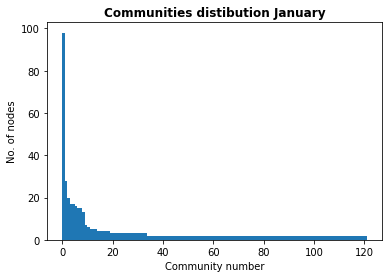

In [66]:
plt.hist(list(best_part.values()), bins=int(size))
plt.xlabel('Community number')
plt.ylabel('No. of nodes')
plt.title('Communities distibution January', weight='bold')
#plt.savefig('plots/communities_dist')
plt.show()

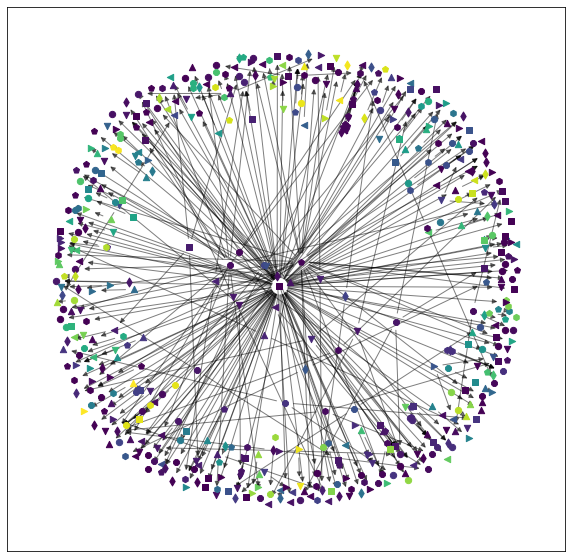

In [19]:
# color the nodes according to their partition
pos = nx.spring_layout(consecutive_retweets_graph_nx)

plt.figure(figsize=(10,10)) 
cmap = mcm.get_cmap('viridis', max(best_part.values()) + 1)
shapes = 'so^>v<dph8'
shapes_iter = 0
for node, color in best_part.items():
    nx.draw_networkx_nodes(consecutive_retweets_graph_nx, pos, [node], node_size=40,
                           node_color=[cmap.colors[color]],
                           node_shape=shapes[shapes_iter])
    shapes_iter +=1
    if shapes_iter == len(shapes):
        shapes_iter=0
nx.draw_networkx_edges(consecutive_retweets_graph_nx, pos, alpha=0.5)
#plt.savefig('plots/communities')
plt.show() #add labels

In [20]:
in_degree_dict = dict(consecutive_retweets_graph_nx.in_degree(consecutive_retweets_graph_nx.nodes()))
sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)

In [21]:
n=5
print("Top n nodes by in_degree (most retweeted users):")
for d in sorted_in_degree[:n]:
    print(f"the node with name {d[0]} , has a in-degree of {d[1]}")

Top n nodes by in_degree (most retweeted users):
the node with name spectatorindex , has a in-degree of 18
the node with name cnn , has a in-degree of 9
the node with name zerohedge , has a in-degree of 8
the node with name bnodesk , has a in-degree of 6
the node with name cnni , has a in-degree of 5


In [22]:
out_degree_dict = dict(consecutive_retweets_graph_nx.out_degree(consecutive_retweets_graph_nx.nodes()))
sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)

In [23]:
n=5
top_out = []
print("Top n nodes by out_degree (most retweeting users):")
for d in sorted_out_degree[:n]:
    print(f"the node with name {d[0]} , has a out-degree of {d[1]}")
    top_out.append(d[0])

Top n nodes by out_degree (most retweeting users):
the node with name viriyabot , has a out-degree of 114
the node with name monitor_ph , has a out-degree of 27
the node with name all100senators , has a out-degree of 16
the node with name all435reps , has a out-degree of 15
the node with name stirlospace , has a out-degree of 5


In [73]:
consecutive_retweets_no_self['user_community'] = consecutive_retweets_no_self['user_screen_name'].map(best_part)
consecutive_retweets_no_self['rt_user_community'] = consecutive_retweets_no_self['rt_user_screen_name'].map(best_part)
consecutive_retweets_no_self.sort_values(by='counts', ascending=False).head(10)

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community
855,dokscho,business,194,11,11
2062,njmike731,cnn,149,7,7
2958,viriyabot,reuters,60,0,9
1632,kjgheroman,cnn,58,7,7
856,dokscho,businessinsider,57,11,11
1958,monitor_ph,who,47,1,7
2971,viriyabot,scmpnews,43,0,0
1929,monitor_ph,cdcgov,35,1,1
2066,njmike731,who,25,7,7
2793,unlvgrad03,boardingarea,22,32,32


In [25]:
top_out_community = {k: v for k, v in best_part.items() if k in top_out}
top_out_community

{'all100senators': 4,
 'all435reps': 5,
 'monitor_ph': 1,
 'stirlospace': 6,
 'viriyabot': 0}

In [26]:
{k: v for k, v in best_part.items() if k=='stirlospace'}

{'stirlospace': 6}

In [75]:
community_number = 0
comm_0 = consecutive_retweets_no_self[(consecutive_retweets_no_self['user_community']==community_number)|(consecutive_retweets_no_self['rt_user_community']==community_number)]
comm_0_graph = nx.from_pandas_edgelist(comm_0,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_0_graph))

Name: 
Type: DiGraph
Number of nodes: 122
Number of edges: 121
Average in degree:   0.9918
Average out degree:   0.9918


In [ ]:
comm_0[(comm_0['user_screen_name']=='dailymail')|(comm_0['rt_user_screen_name']=='dailymail')]

In [74]:
consecutive_retweets_no_self[(consecutive_retweets_no_self['user_screen_name']=='dailymail')|(consecutive_retweets_no_self['rt_user_screen_name']=='dailymail')]

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community
763,dailymail,dailymailuk,2,23,23
764,dailymail,mailonline,5,23,23
765,dailymailuk,dailymail,3,23,23
1766,mailonline,dailymail,6,23,23


In [72]:
best_part

{'13abc': 34,
 'mmarshalltv': 34,
 '4cs3420': 19,
 'baucyan1': 19,
 '4tchat': 20,
 'ilovejammu_': 20,
 'superfreeborn': 20,
 '5cs3420': 19,
 '710wor': 35,
 'lenmichaelwor': 35,
 '79wasagreatyear': 7,
 'cnn': 7,
 '_imericsistable': 7,
 '_lydiamj': 6,
 'bnodesk': 6,
 'abctricities': 36,
 'wjhl11': 36,
 'abytorresjr': 2,
 'spectatorindex': 2,
 'ace135q': 3,
 'firstsquawk': 3,
 'mdlive4': 3,
 'themarketear': 3,
 'actualidadrt': 37,
 'rtultimahora': 37,
 'airplusnews': 38,
 'airplusnews_en': 38,
 'airrickbrown': 0,
 'nowthisnews': 0,
 'all100senators': 4,
 'chriscoons': 4,
 'pattymurray': 4,
 'senalexander': 4,
 'senatorbaldwin': 4,
 'senatorcantwell': 4,
 'senatordurbin': 4,
 'senatorhassan': 4,
 'senatormenendez': 4,
 'senatorshaheen': 4,
 'senduckworth': 4,
 'senfeinstein': 4,
 'sengarypeters': 4,
 'senjeffmerkley': 4,
 'senrickscott': 4,
 'senrobportman': 4,
 'sentomcotton': 4,
 'all435reps': 5,
 'auctnr1': 5,
 'frankpallone': 5,
 'michaelcburgess': 5,
 'repanniekuster': 5,
 'repbillfos

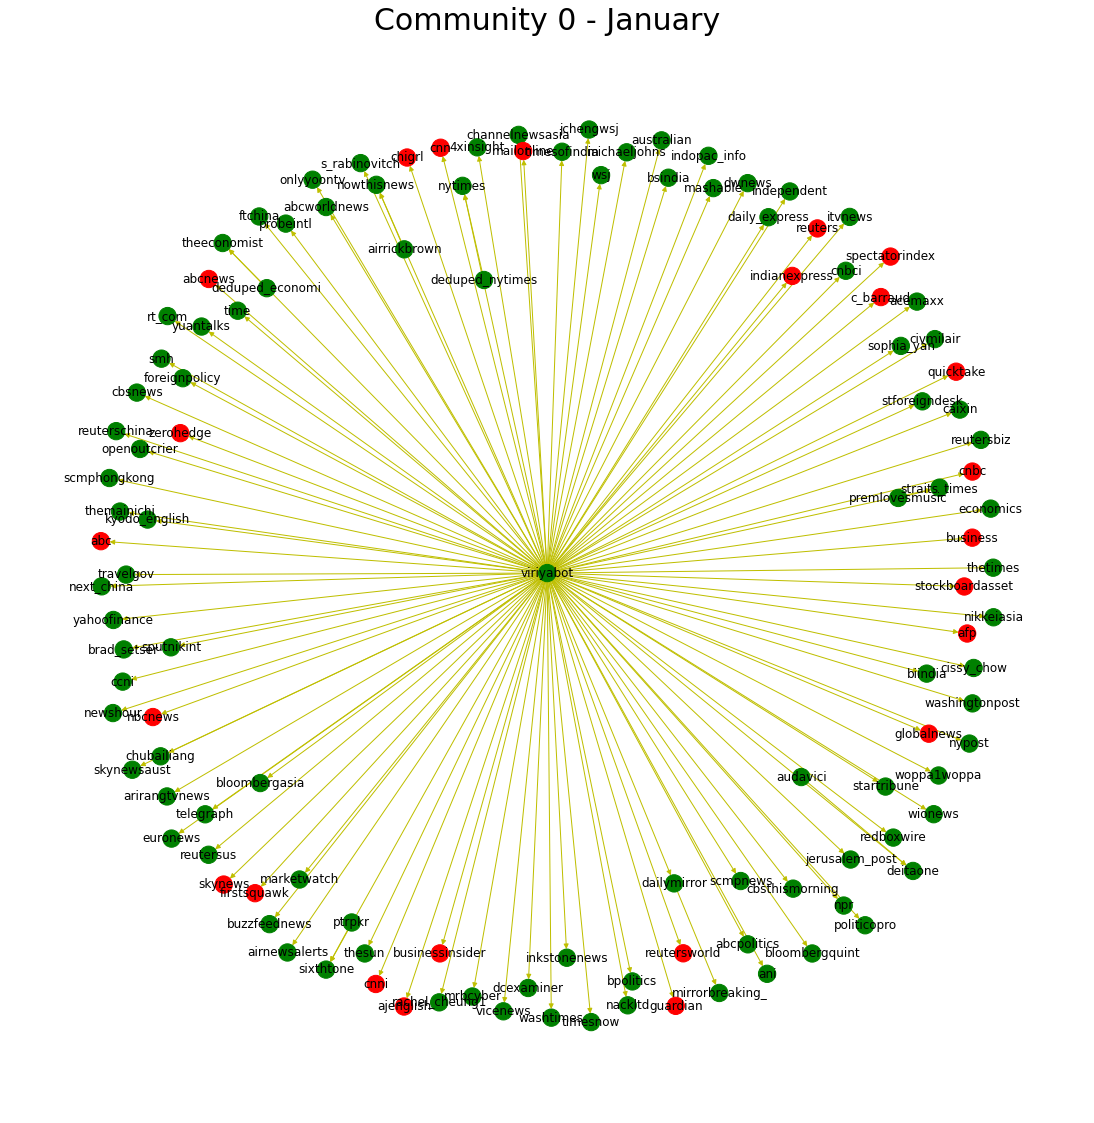

In [89]:
graph_to_print = comm_0_graph
labels = {}    
color_map = ['g']*len(graph_to_print.nodes())
idx = 0
for node in graph_to_print.nodes():
    labels[node] = node
    if best_part[node] != community_number:
        color_map[idx] = 'r'
    idx+=1
plt.figure(figsize=(15,15)) 
graph_to_print_relabel = nx.relabel_nodes(graph_to_print, labels)


nx.draw(graph_to_print_relabel, with_labels=True, node_color=color_map, edge_color='y')
plt.title('Community 0 - January', fontsize=30)
plt.savefig(path+'plots/coordinated/comm_0_january', bbox_inches='tight')
plt.show()

In [79]:
best_part['dailymail']

23

In [83]:
{k: v for k, v in best_part.items() if v ==23}

{'dailymail': 23, 'dailymailuk': 23, 'mailonline': 23}

In [82]:
{k: v for k, v in best_part.items() if v ==0}

{'airrickbrown': 0,
 'nowthisnews': 0,
 'audavici': 0,
 'deitaone': 0,
 'dailymirror': 0,
 'mirrorbreaking_': 0,
 'deduped_economi': 0,
 'theeconomist': 0,
 'deduped_nytimes': 0,
 'nytimes': 0,
 'premlovesmusic': 0,
 'straits_times': 0,
 'ptrpkr': 0,
 'sixthtone': 0,
 'viriyabot': 0,
 '4xinsight': 0,
 'abcpolitics': 0,
 'abcworldnews': 0,
 'acemaxx': 0,
 'airnewsalerts': 0,
 'ani': 0,
 'arirangtvnews': 0,
 'australian': 0,
 'biindia': 0,
 'bloombergasia': 0,
 'bloombergquint': 0,
 'bpolitics': 0,
 'brad_setser': 0,
 'bsindia': 0,
 'buzzfeednews': 0,
 'caixin': 0,
 'cbsnews': 0,
 'cbsthismorning': 0,
 'ccni': 0,
 'channelnewsasia': 0,
 'chubailiang': 0,
 'cissy_chow': 0,
 'civmilair': 0,
 'cnbci': 0,
 'daily_express': 0,
 'dcexaminer': 0,
 'dwnews': 0,
 'economics': 0,
 'euronews': 0,
 'foreignpolicy': 0,
 'ftchina': 0,
 'independent': 0,
 'indopac_info': 0,
 'inkstonenews': 0,
 'itvnews': 0,
 'jchengwsj': 0,
 'jerusalem_post': 0,
 'kyodo_english': 0,
 'marketwatch': 0,
 'mashable': 0,


In [29]:
consecutive_retweets_no_self[(consecutive_retweets_no_self['user_screen_name']=='dailymail')|(consecutive_retweets_no_self['rt_user_screen_name']=='dailymail')]

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community
1853,dailymail,mailonline,3,0,0
4986,mailonline,dailymail,5,0,0


In [30]:
consecutive_retweets_no_self[(consecutive_retweets_no_self['user_screen_name']=='mailonline')|(consecutive_retweets_no_self['rt_user_screen_name']=='mailonline')]

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community
1853,dailymail,mailonline,3,0,0
1855,dailymailuk,mailonline,4,0,0
4986,mailonline,dailymail,5,0,0
4987,mailonline,dailymailuk,9,0,0
8549,viriyabot,mailonline,4,0,0


In [31]:
consecutive_retweets_no_self[(consecutive_retweets_no_self['user_screen_name']=='dailymailuk')|(consecutive_retweets_no_self['rt_user_screen_name']=='dailymailuk')]

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community
1855,dailymailuk,mailonline,4,0,0
4987,mailonline,dailymailuk,9,0,0
8484,viriyabot,dailymailuk,2,0,0


In [32]:
consecutive_retweets_no_self[(consecutive_retweets_no_self['user_screen_name']=='nathanjohn878')|(consecutive_retweets_no_self['rt_user_screen_name']=='nathanjohn878')]

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community
5578,nathanjohn878,economics,2,0,0
5579,nathanjohn878,marketwatch,2,0,0
5581,nathanjohn878,reuters,8,0,8


In [37]:
consecutive_retweets_no_self[(consecutive_retweets_no_self['user_screen_name']=='indianexpress')|(consecutive_retweets_no_self['rt_user_screen_name']=='indianexpress')]

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community
3880,indianexpress,expresstechie,11,0,0
3882,indianexpress,ietrending,5,0,0
8521,viriyabot,indianexpress,9,0,0


In [91]:
community_number = 1
comm_1 = consecutive_retweets_no_self[(consecutive_retweets_no_self['user_community']==community_number)|(consecutive_retweets_no_self['rt_user_community']==community_number)]
comm_1_graph = nx.from_pandas_edgelist(comm_1,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_1_graph))

Name: 
Type: DiGraph
Number of nodes: 29
Number of edges: 28
Average in degree:   0.9655
Average out degree:   0.9655


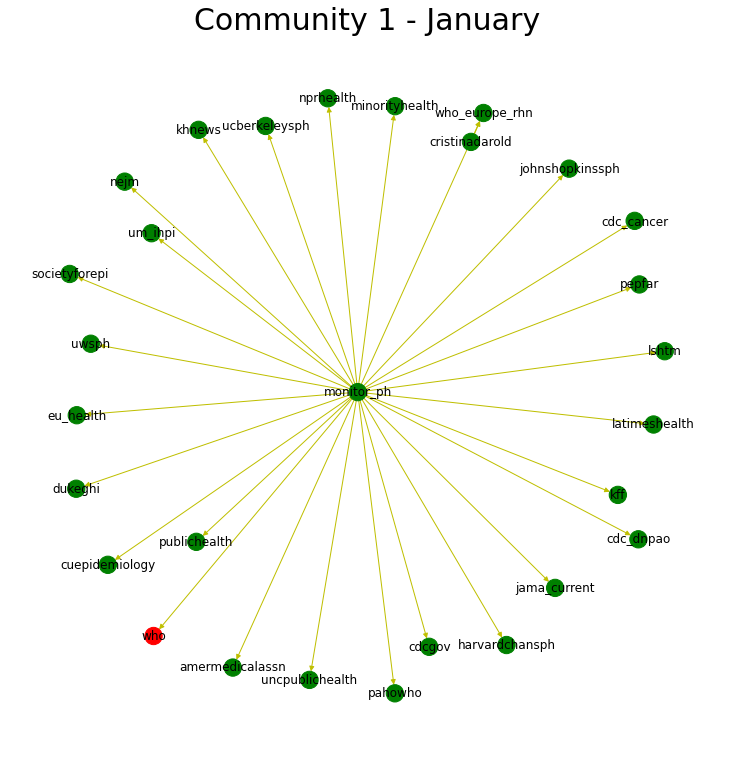

In [92]:
graph_to_print = comm_1_graph
labels = {}    
color_map = ['g']*len(graph_to_print.nodes())
idx = 0
for node in graph_to_print.nodes():
    labels[node] = node
    if best_part[node] != community_number:
        color_map[idx] = 'r'
    idx+=1
plt.figure(figsize=(10,10)) 
graph_to_print_relabel = nx.relabel_nodes(graph_to_print, labels)


nx.draw(graph_to_print_relabel, with_labels=True, node_color=color_map, edge_color='y')
plt.title('Community 1 - January', fontsize=30)
plt.savefig(path+'plots/coordinated/comm_1_january', bbox_inches='tight')
plt.show()

In [38]:
{k: v for k, v in best_part.items() if v ==1}

{'cristinadarold': 1,
 'who_europe_rhn': 1,
 'monitor_ph': 1,
 'amermedicalassn': 1,
 'cdc_cancer': 1,
 'cdc_dnpao': 1,
 'cdcgov': 1,
 'cuepidemiology': 1,
 'dukeghi': 1,
 'eu_health': 1,
 'harvardchansph': 1,
 'jama_current': 1,
 'johnshopkinssph': 1,
 'kff': 1,
 'khnews': 1,
 'latimeshealth': 1,
 'lshtm': 1,
 'minorityhealth': 1,
 'nejm': 1,
 'nprhealth': 1,
 'pahowho': 1,
 'pepfar': 1,
 'publichealth': 1,
 'societyforepi': 1,
 'ucberkeleysph': 1,
 'um_ihpi': 1,
 'uncpublichealth': 1,
 'uwsph': 1}

In [93]:
community_number = 2
comm_2 = consecutive_retweets_no_self[(consecutive_retweets_no_self['user_community']==community_number)|(consecutive_retweets_no_self['rt_user_community']==community_number)]
comm_2_graph = nx.from_pandas_edgelist(comm_2,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_2_graph))

Name: 
Type: DiGraph
Number of nodes: 22
Number of edges: 21
Average in degree:   0.9545
Average out degree:   0.9545


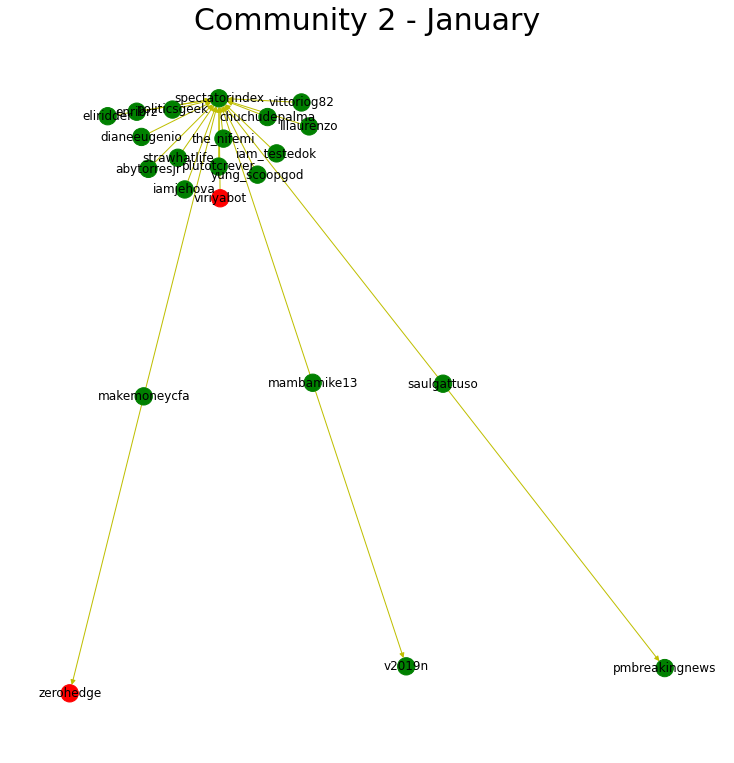

In [99]:
graph_to_print = comm_2_graph
labels = {}    
color_map = ['g']*len(graph_to_print.nodes())
idx = 0
for node in graph_to_print.nodes():
    labels[node] = node
    if best_part[node] != community_number:
        color_map[idx] = 'r'
    idx+=1
plt.figure(figsize=(10,10)) 
graph_to_print_relabel = nx.relabel_nodes(graph_to_print, labels)


nx.draw(graph_to_print_relabel, with_labels=True, node_color=color_map, edge_color='y')
plt.title('Community 2 - January', fontsize=30)
plt.savefig(path+'plots/coordinated/comm_2_january', bbox_inches='tight')
plt.show()

In [100]:
community_number = 3
comm_3 = consecutive_retweets_no_self[(consecutive_retweets_no_self['user_community']==community_number)|(consecutive_retweets_no_self['rt_user_community']==community_number)]
comm_3_graph = nx.from_pandas_edgelist(comm_3,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_3_graph))

Name: 
Type: DiGraph
Number of nodes: 19
Number of edges: 21
Average in degree:   1.1053
Average out degree:   1.1053


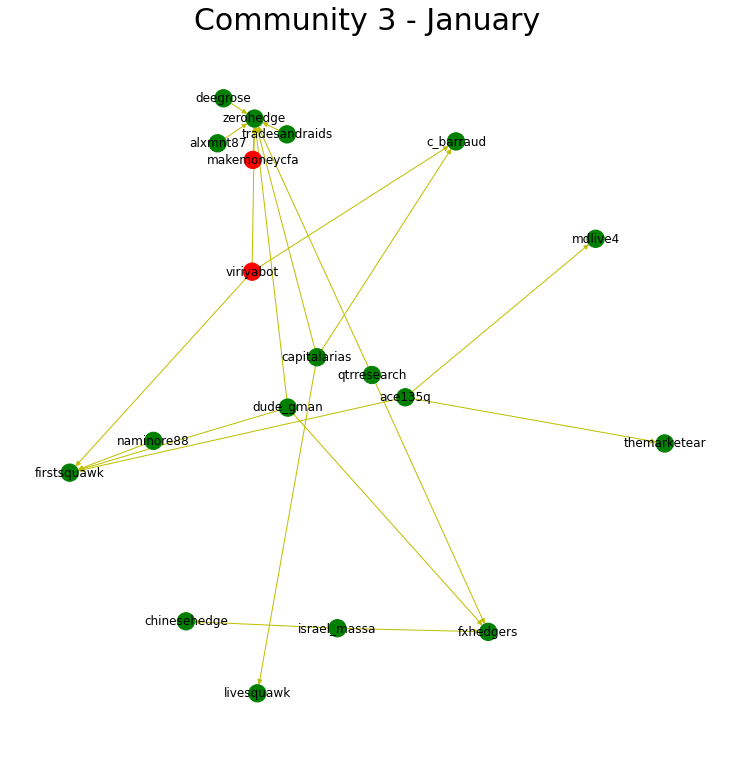

In [103]:
graph_to_print = comm_3_graph
labels = {}    
color_map = ['g']*len(graph_to_print.nodes())
idx = 0
for node in graph_to_print.nodes():
    labels[node] = node
    if best_part[node] != community_number:
        color_map[idx] = 'r'
    idx+=1
plt.figure(figsize=(10,10)) 
graph_to_print_relabel = nx.relabel_nodes(graph_to_print, labels)


nx.draw(graph_to_print_relabel, with_labels=True, node_color=color_map, edge_color='y')
plt.title('Community 3 - January', fontsize=30)
plt.savefig(path+'plots/coordinated/comm_3_january', bbox_inches='tight')
plt.show()

In [104]:
community_number = 4
comm_4 = consecutive_retweets_no_self[(consecutive_retweets_no_self['user_community']==community_number)|(consecutive_retweets_no_self['rt_user_community']==community_number)]
comm_4_graph = nx.from_pandas_edgelist(comm_4,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_4_graph))

Name: 
Type: DiGraph
Number of nodes: 17
Number of edges: 16
Average in degree:   0.9412
Average out degree:   0.9412


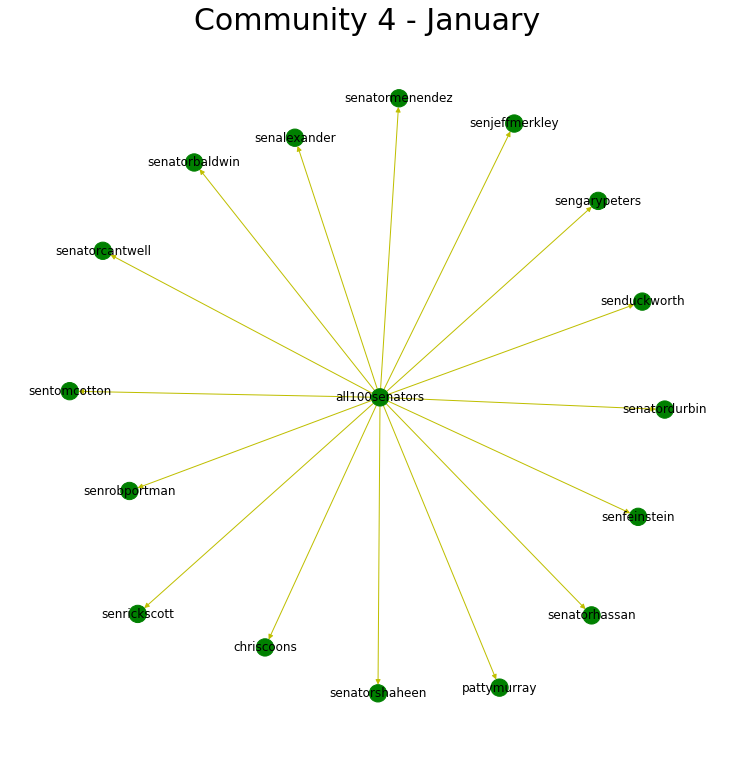

In [105]:
graph_to_print = comm_4_graph
labels = {}    
color_map = ['g']*len(graph_to_print.nodes())
idx = 0
for node in graph_to_print.nodes():
    labels[node] = node
    if best_part[node] != community_number:
        color_map[idx] = 'r'
    idx+=1
plt.figure(figsize=(10,10)) 
graph_to_print_relabel = nx.relabel_nodes(graph_to_print, labels)


nx.draw(graph_to_print_relabel, with_labels=True, node_color=color_map, edge_color='y')
plt.title('Community 4 - January', fontsize=30)
plt.savefig(path+'plots/coordinated/comm_4_january', bbox_inches='tight')
plt.show()

In [106]:
community_number = 5
comm_5 = consecutive_retweets_no_self[(consecutive_retweets_no_self['user_community']==community_number)|(consecutive_retweets_no_self['rt_user_community']==community_number)]
comm_5_graph = nx.from_pandas_edgelist(comm_5,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_5_graph))

Name: 
Type: DiGraph
Number of nodes: 16
Number of edges: 15
Average in degree:   0.9375
Average out degree:   0.9375


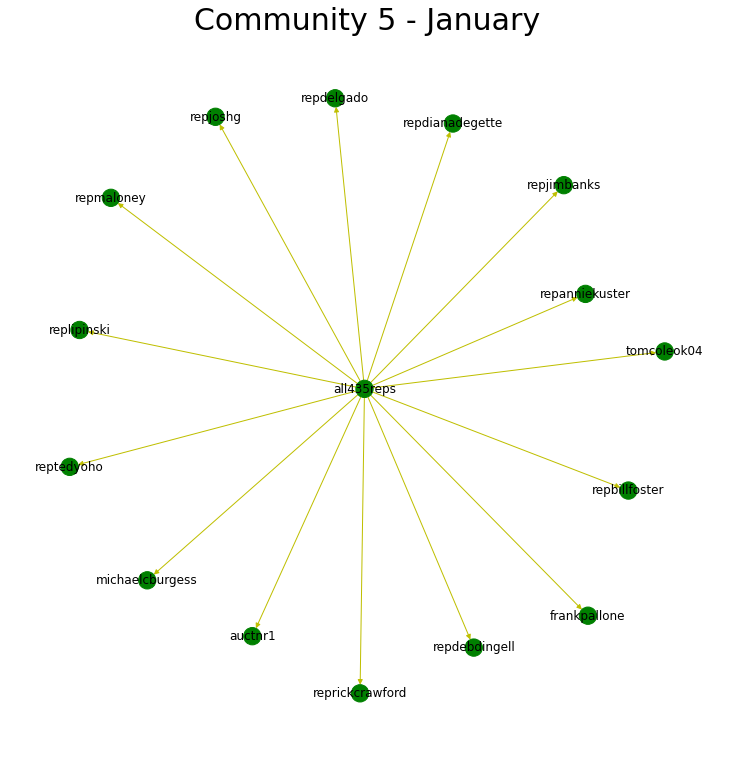

In [107]:
graph_to_print = comm_5_graph
labels = {}    
color_map = ['g']*len(graph_to_print.nodes())
idx = 0
for node in graph_to_print.nodes():
    labels[node] = node
    if best_part[node] != community_number:
        color_map[idx] = 'r'
    idx+=1
plt.figure(figsize=(10,10)) 
graph_to_print_relabel = nx.relabel_nodes(graph_to_print, labels)


nx.draw(graph_to_print_relabel, with_labels=True, node_color=color_map, edge_color='y')
plt.title('Community 5 - January', fontsize=30)
plt.savefig(path+'plots/coordinated/comm_5_january', bbox_inches='tight')
plt.show()

In [108]:
community_number = 6
comm_6 = consecutive_retweets_no_self[(consecutive_retweets_no_self['user_community']==community_number)|(consecutive_retweets_no_self['rt_user_community']==community_number)]
comm_6_graph = nx.from_pandas_edgelist(comm_6,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_6_graph))

Name: 
Type: DiGraph
Number of nodes: 16
Number of edges: 19
Average in degree:   1.1875
Average out degree:   1.1875


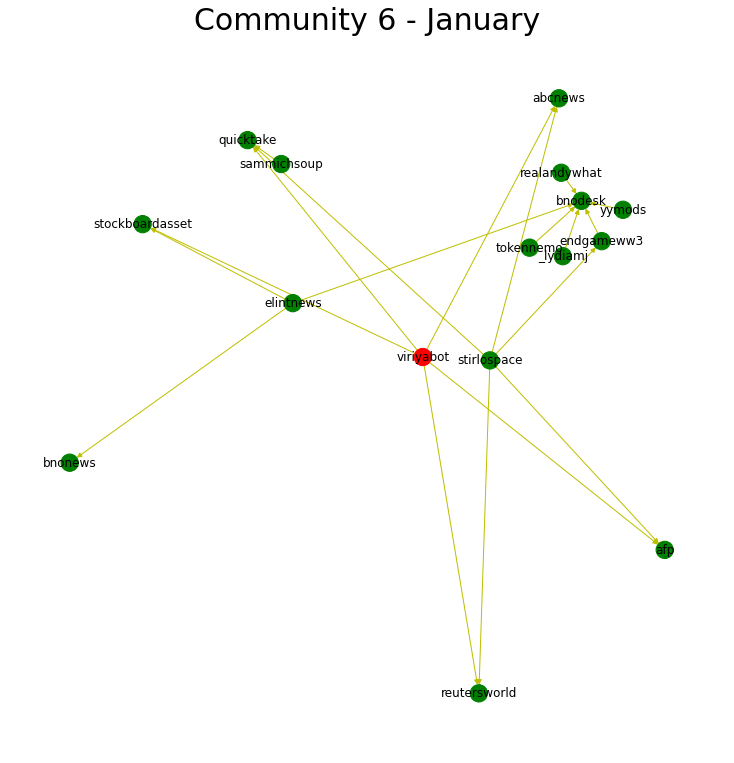

In [109]:
graph_to_print = comm_6_graph
labels = {}    
color_map = ['g']*len(graph_to_print.nodes())
idx = 0
for node in graph_to_print.nodes():
    labels[node] = node
    if best_part[node] != community_number:
        color_map[idx] = 'r'
    idx+=1
plt.figure(figsize=(10,10)) 
graph_to_print_relabel = nx.relabel_nodes(graph_to_print, labels)


nx.draw(graph_to_print_relabel, with_labels=True, node_color=color_map, edge_color='y')
plt.title('Community 6 - January', fontsize=30)
plt.savefig(path+'plots/coordinated/comm_6_january', bbox_inches='tight')
plt.show()

In [59]:
consecutive_retweets_no_self[(consecutive_retweets_no_self['user_screen_name']=='eliteozzy')|(consecutive_retweets_no_self['rt_user_screen_name']=='eliteozzy')]

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community


In [62]:
tweets[tweets['user_screen_name']=='eliteozzy']

,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,text,source,coordinates,...,quoted_status_text,quoted_status_created_at,quoted_user_id,quoted_user_created_at,hashtags,symbols,user_mentions,urls,polls,media


In [110]:
best_part['straightthinked']

KeyError: 'straightthinked'

In [111]:
best_part['zerohedge']

3

In [113]:
best_part['alxmnt87']

3

In [114]:
best_part['capitalarias']

3

In [115]:
best_part['deegrose']

3

In [116]:
best_part['dude_gman']

3

In [117]:
best_part['makemoneycfa']

2

In [118]:
best_part['qtrresearch']

3

In [120]:
best_part['tradesandraids']

3

In [121]:
best_part['caixin']

0

# Retweets

In [11]:
retweets = tweets.dropna(subset=['rt_created_at'])

In [12]:
retweets_count = retweets.groupby(['user_screen_name','rt_user_screen_name']).size().reset_index(name='counts')
retweets_count.sort_values(by='counts', ascending=False).head(10)

,user_screen_name,rt_user_screen_name,counts
2677084,viriyabot,reuters,270
635936,daddy_cwell2019,reuters,248
728436,dokscho,business,203
2735696,world_news_eng,reuters,203
2432825,stankaba,reuters,198
2677119,viriyabot,scmpnews,180
1141289,ikateufel,cnn,180
1921026,njmike731,cnn,149
2721312,willygaleon,abscbnnews,133
2061778,phildecarolis,zerohedge,131


In [13]:
print('January')
retweets_graph_nx = nx.from_pandas_edgelist(retweets_count,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(retweets_graph_nx))
isolated_nodes = list(nx.isolates(retweets_graph_nx))
print('Isoleted nodes:',len(isolated_nodes))
print('Strongly connected: ',nx.is_strongly_connected(retweets_graph_nx))
print('Number of connected components: ',nx.number_strongly_connected_components(retweets_graph_nx))
#print('Number of non connected components: ',len(nx.nodes(consecutive_retweets_graph_nx))-nx.number_strongly_connected_components(consecutive_retweets_graph_nx))
# Extract the giant connected component
Gcc = sorted((retweets_graph_nx.subgraph(c) for c in nx.strongly_connected_components(retweets_graph_nx)), key = len,reverse=True)[0]
print("Number of nodes in the Gcc graph: ",len(Gcc.nodes()))
print("Number of edges in the Gcc graph: ",len(Gcc.edges()))
#print("Gcc nodes: ",Gcc.nodes())
#print("Gcc edges: ",Gcc.edges())

January
Name: 
Type: DiGraph
Number of nodes: 1578936
Number of edges: 2828224
Average in degree:   1.7912
Average out degree:   1.7912
Isoleted nodes: 0
Strongly connected:  False
Number of connected components:  1571936
Number of nodes in the Gcc graph:  6139
Number of edges in the Gcc graph:  39724
Gcc nodes:  ['breakfastnews', 'blahblahbleh14', 'peckpolitics', 'emilyhwoods', 'marcboni', 'eaglewarrior427', 'collide_09', 'ahmedbaba_', 'uosmedia', 'cbcqueenspark', 'dcheng36387164', 'dannywztl0522', 'imacuriosguy', 'dabumm2u', 'cape_diamond', 'ryankiro7', 'tdanetwork', 'arabbitorduck', 'richforrest2', 'tigermudra', 'met417133', 'jay_usmc2', 'maolo_hkg', 'oknox', 'wycked_yum', 'virusesimmunity', 'syahredzan', 'byron_hou', 'k_r_n_o', 'smurfette017', 'edgarray97', 'kanookandchook', 'robertalanward', 'hodgeamanda', 'tilly64', 'freehkleeds', 'gloriakonghkg', 'ferdimagellan2', 'nenagh9', 'market_overview', 'imax111', 'thuyong', 'democratie_kate', 'ewster', 'randaltsrandal', 'claeysteven', 'l

Gcc edges:  [('breakfastnews', 'mjrowland68'), ('blahblahbleh14', 'bueti'), ('blahblahbleh14', 'business'), ('blahblahbleh14', 'cbsthismorning'), ('blahblahbleh14', 'dcexaminer'), ('blahblahbleh14', 'financialtimes'), ('blahblahbleh14', 'indopac_info'), ('blahblahbleh14', 'latimes'), ('blahblahbleh14', 'lowyinstitute'), ('blahblahbleh14', 'nytimesbusiness'), ('blahblahbleh14', 'ramyinocencio'), ('blahblahbleh14', 'reuters'), ('blahblahbleh14', 'reutersworld'), ('blahblahbleh14', 'rmdkenny'), ('blahblahbleh14', 'senrickscott'), ('blahblahbleh14', 'telegraph'), ('blahblahbleh14', 'theatlantic'), ('blahblahbleh14', 'viviennechow'), ('blahblahbleh14', 'washingtonpost'), ('peckpolitics', 'columbiabugle'), ('peckpolitics', 'harmlessyarddog'), ('peckpolitics', 'scottgottliebmd'), ('emilyhwoods', 'bradendavy'), ('emilyhwoods', 'emilyrauhala'), ('marcboni', 'elliottkaybooks'), ('eaglewarrior427', '1120eclipse'), ('eaglewarrior427', 'chicola_nola'), ('eaglewarrior427', 'dreadrea_g'), ('eaglewarr

In [14]:
tuples = [tuple(x) for x in retweets_count.values]
retweets_graph = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['counts'])

In [15]:
n_vertices = retweets_graph.vcount()
print("Number of vertices:", n_vertices)
print("Number of edges:", retweets_graph.ecount())
print("Density of the graph:", 2*retweets_graph.ecount()/(retweets_graph.vcount()*(retweets_graph.vcount()-1)))

Number of vertices: 1578936
Number of edges: 2828224
Density of the graph: 2.268898251197966e-06


In [17]:
partition = la.find_partition(retweets_graph, la.ModularityVertexPartition)
zip_iterator = zip(retweets_graph.vs()["name"], partition.membership)
best_part = dict(zip_iterator)
best_part

{'0000000francis': 0,
 'joeltkl': 0,
 '000000juuh': 1,
 'voanews': 1,
 '000001000kkkkk': 15,
 'barceilos': 15,
 '000001111lll': 6,
 'alfredpoprock': 6,
 '00000365': 9,
 'cnni': 2,
 'who': 9,
 '00000__b': 1,
 'cnnphilippines': 1,
 'gideonlasco': 1,
 'inigoabellar': 1,
 'joeyalarilla': 1,
 'stephjaurigue': 1,
 'whophilippines': 1,
 '00000o0oooo00': 2,
 'afp': 2,
 '00001noname': 29,
 'amin__ur': 29,
 '0000artist000': 5,
 'dadetrading': 5,
 '0000claphanz': 4,
 'cnn': 4,
 '0000dae': 0,
 'hanbinniex': 0,
 '0000dd02': 10,
 'putneyswoped': 10,
 'senateforeign': 10,
 '0000elliot0000': 21,
 'bsadams25': 21,
 'hometobilo': 21,
 '0000hour': 432,
 'gamasutra': 432,
 '0000seapea808': 42,
 'dadmann_walking': 42,
 '0000vinnerchild': 3,
 'simuliu': 3,
 '0000x0345': 6,
 'truecarnivorepk': 6,
 '0000yes1': 11,
 'pdchina': 11,
 '00012honey': 15,
 'agencialupa': 15,
 'camilabomfim': 15,
 'cgtnamerica': 11,
 'esquizochanel': 15,
 '0001sudarshan': 14,
 'hvgoenka': 14,
 '0001txt': 3,
 'elliottkaybooks': 3,
 '0

In [18]:
size = float(len(set(best_part.values())))
print("Number of communities: ", size)

Number of communities:  34675.0


In [19]:
#check that sum of each community size = number of nodes
communities_size = np.zeros(len(set(best_part.values())))
for v in list(best_part.values()):
    communities_size[v] +=1
print(sum(communities_size))

1578936.0


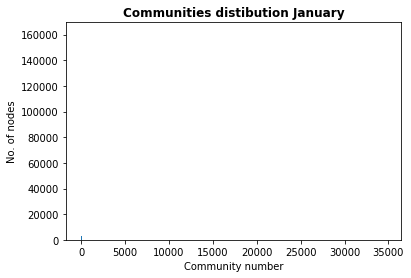

In [24]:
plt.hist(list(best_part.values()), bins=int(size))
plt.xlabel('Community number')
plt.ylabel('No. of nodes')
plt.title('Communities distibution January', weight='bold')
#plt.savefig('plots/communities_dist')
plt.show()

In [49]:
in_degree_dict = dict(retweets_graph_nx.in_degree(retweets_graph_nx.nodes()))
sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)
n=20
top_in = []
print("Top n nodes by in_degree (most retweeted users):")
for d in sorted_in_degree[:n]:
    print(f"the node with name {d[0]} , has a in-degree of {d[1]}")
    top_in.append(d[0])

Top n nodes by in_degree (most retweeted users):
the node with name joeltkl , has a in-degree of 57528
the node with name wiishiit , has a in-degree of 48605
the node with name simuliu , has a in-degree of 31209
the node with name spectatorindex , has a in-degree of 30330
the node with name helloalegria , has a in-degree of 26374
the node with name dadetrading , has a in-degree of 24581
the node with name emtpyvase , has a in-degree of 23127
the node with name hanbinniex , has a in-degree of 20975
the node with name who , has a in-degree of 20376
the node with name kaizokunigga , has a in-degree of 19777
the node with name cnn , has a in-degree of 18407
the node with name unkle_k , has a in-degree of 15722
the node with name new_prykm , has a in-degree of 13834
the node with name cnni , has a in-degree of 13012
the node with name reuters , has a in-degree of 12832
the node with name scmpnews , has a in-degree of 12804
the node with name badiucao , has a in-degree of 12548
the node with

In [48]:
out_degree_dict = dict(retweets_graph_nx.out_degree(retweets_graph_nx.nodes()))
sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)
n=20
top_out = []
print("Top n nodes by out_degree (most retweeting users):")
for d in sorted_out_degree[:n]:
    print(f"the node with name {d[0]} , has a out-degree of {d[1]}")
    top_out.append(d[0])

Top n nodes by out_degree (most retweeting users):
the node with name 4tchat , has a out-degree of 1375
the node with name generate_output , has a out-degree of 735
the node with name viriyabot , has a out-degree of 704
the node with name gambiste1 , has a out-degree of 306
the node with name publichealthbot , has a out-degree of 292
the node with name makoto_au_japon , has a out-degree of 280
the node with name sheltgarner , has a out-degree of 256
the node with name loserleaves , has a out-degree of 244
the node with name sumanebot , has a out-degree of 230
the node with name gailcoastie , has a out-degree of 229
the node with name anthraxxxx , has a out-degree of 226
the node with name familydisaster , has a out-degree of 226
the node with name ivonnesosasanm1 , has a out-degree of 216
the node with name protestmusica , has a out-degree of 216
the node with name flight_refunds , has a out-degree of 215
the node with name oniononion39 , has a out-degree of 215
the node with name cost

In [41]:
fast_retweet_users = list(set(list(consecutive_retweets_count['user_screen_name']) + list(consecutive_retweets_count['rt_user_screen_name'])))

In [58]:
print('Fast retweet users & most retweeted users:')
for user in top_in:
    if user in fast_retweet_users:
        print(user)

Fast retweet users & most retweeted users:
spectatorindex
who
cnn
cnni
reuters
scmpnews


In [59]:
print('Fast retweet users & most retweeting users:')
for user in top_out:
    if user in fast_retweet_users:
        print(user)
#tutti e tre bot

Fast retweet users & most retweeting users:
4tchat
generate_output
viriyabot


In [60]:
print('Most retweeted users - community:')
{k: v for k, v in best_part.items() if k in top_in}

Most retweeted users - community:


{'joeltkl': 0,
 'cnni': 2,
 'who': 9,
 'dadetrading': 5,
 'cnn': 4,
 'hanbinniex': 0,
 'simuliu': 3,
 'spectatorindex': 7,
 'sosyolohija': 1,
 'tobiithedreamer': 3,
 'wiishiit': 12,
 'unkle_k': 13,
 'reuters': 2,
 'scmpnews': 0,
 'kaizokunigga': 5,
 'badiucao': 2,
 'emtpyvase': 19,
 'aminsyafee': 0,
 'helloalegria': 3,
 'new_prykm': 0}

In [61]:
print('Most retweeting users - community:')
{k: v for k, v in best_part.items() if k in top_out}

Most retweeting users - community:


{'tomsnews_': 2,
 '4tchat': 2,
 'costellodaniel1': 2,
 'dm6891': 2,
 'generate_output': 2,
 'makoto_au_japon': 2,
 'sheltgarner': 2,
 'gailcoastie': 21,
 'anthraxxxx': 0,
 'familydisaster': 2,
 'flight_refunds': 17,
 'gambiste1': 2,
 'loserleaves': 2,
 'hky2147': 2,
 'ivonnesosasanm1': 8,
 'oniononion39': 2,
 'protestmusica': 14,
 'publichealthbot': 27,
 'sumanebot': 11,
 'viriyabot': 2}

In [55]:
users[users['screen_name']=='generate_output']['created_at']

7560    Tue Sep 06 12:50:41 +0000 2016
Name: created_at, dtype: object

In [29]:
retweets_count['user_community'] = retweets_count['user_screen_name'].map(best_part)
retweets_count['rt_user_community'] = retweets_count['rt_user_screen_name'].map(best_part)
retweets_count.sort_values(by='counts', ascending=False).head(10)

,user_screen_name,rt_user_screen_name,counts,user_community,rt_user_community
2677084,viriyabot,reuters,270,2,2
635936,daddy_cwell2019,reuters,248,17,2
728436,dokscho,business,203,2,2
2735696,world_news_eng,reuters,203,2,2
2432825,stankaba,reuters,198,2,2
2677119,viriyabot,scmpnews,180,2,0
1141289,ikateufel,cnn,180,4,4
1921026,njmike731,cnn,149,23,4
2721312,willygaleon,abscbnnews,133,1,1
2061778,phildecarolis,zerohedge,131,11,2


In [30]:
top_out_community = {k: v for k, v in best_part.items() if k in top_out}
top_out_community

{'4tchat': 2,
 'generate_output': 2,
 'gambiste1': 2,
 'publichealthbot': 27,
 'viriyabot': 2}

In [31]:
community_number = 0
comm_0 = retweets_count[(retweets_count['user_community']==community_number)|(retweets_count['rt_user_community']==community_number)]
comm_0_graph = nx.from_pandas_edgelist(comm_0,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_0_graph))

Name: 
Type: DiGraph
Number of nodes: 223852
Number of edges: 391908
Average in degree:   1.7507
Average out degree:   1.7507


In [45]:
comm_0_fast_users = []
for node in comm_0_graph.nodes():
    if best_part[node] == community_number:
        if node in fast_retweet_users:
            comm_0_fast_users.append(node)
comm_0_fast_users

['rachel_cheung1',
 'woppa1woppa',
 'reuters',
 'cnni',
 'bnodesk',
 'sentomcotton',
 'asb_breaking',
 'business',
 'marketwatch',
 'chubailiang',
 'independent',
 'afp',
 'sophia_yan',
 'next_china',
 'indopac_info',
 '4tchat',
 'mailonline',
 'dwnews',
 'foreignpolicy',
 'businessinsider',
 's_rabinovitch',
 'nikkeiasia',
 'reutersworld',
 'bnonews',
 'civmilair',
 'inkstonenews',
 'wsj',
 'auroraintel',
 'washingtonpost',
 'pmbreakingnews',
 'factal',
 'reuterschina',
 'guardian',
 'qtrresearch',
 'dailymailuk',
 'mirrorbreaking_',
 'vicenews',
 'theeconomist',
 'fxhedgers',
 'senrickscott',
 'zerohedge',
 'lookner',
 'cnbc',
 'washtimes',
 'technology',
 'deitaone',
 'reutersbiz',
 'stforeigndesk',
 'cnbcnow',
 'onlyyoontv',
 'travelgov',
 'thesun',
 'abcworldnews',
 'rover829',
 'sputnikint',
 'apex_ww',
 'jerusalem_post',
 'audavici',
 'caixin',
 'ccni',
 'jchengwsj',
 'cissy_chow',
 'yuantalks',
 'ckpolitics23',
 'nypost',
 'dailymirror',
 'dawnindark',
 'endgameww3',
 'telegrap

In [34]:
community_number = 2
comm_2 = retweets_count[(retweets_count['user_community']==community_number)|(retweets_count['rt_user_community']==community_number)]
comm_2_graph = nx.from_pandas_edgelist(comm_2,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(comm_2_graph))

Name: 
Type: DiGraph
Number of nodes: 191072
Number of edges: 486529
Average in degree:   2.5463
Average out degree:   2.5463


In [46]:
comm_2_fast_users = []
for node in comm_2_graph.nodes():
    if best_part[node] == community_number:
        if node in fast_retweet_users:
            comm_2_fast_users.append(node)
comm_2_fast_users

['cnni',
 'afp',
 'bnonews',
 'zerohedge',
 'sentomcotton',
 'mailonline',
 'asb_breaking',
 'auroraintel',
 'bnodesk',
 'firstsquawk',
 'indopac_info',
 'jchengwsj',
 'reuters',
 'stockboardasset',
 'w7voa',
 'independent',
 'sputnikint',
 'business',
 'cnbc',
 'nikkeiasia',
 'qtrresearch',
 'deitaone',
 'wsj',
 'dailymirror',
 'cnbcnow',
 'dcexaminer',
 'woppa1woppa',
 'vicenews',
 'dwnews',
 'thesun',
 'guardian',
 'theeconomist',
 'washingtonpost',
 'chubailiang',
 'scmphongkong',
 'rachel_cheung1',
 'sophia_yan',
 'repjimbanks',
 'foreignpolicy',
 'reutersworld',
 'senrobportman',
 'next_china',
 'lookner',
 'washtimes',
 'reuterschina',
 'rover829',
 'acemaxx',
 'chigrl',
 'fxhedgers',
 'yuantalks',
 's_rabinovitch',
 'abcworldnews',
 'cbsthismorning',
 'reptedyoho',
 'senrickscott',
 'telegraph',
 'technology',
 'eveningstandard',
 'onlyyoontv',
 'dailymail',
 'caixin',
 'civmilair',
 'jerusalem_post',
 'endgameww3',
 'l0gg0l',
 'elintnews',
 'inteldoge',
 'pmbreakingnews',
 'fa